In [1]:
from pygraphblas import *
from itertools import repeat
import random
from numba import njit
from pygraphblas.demo.gviz import draw

In [2]:
M = Matrix.from_lists(
    [0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5, 5,
    6, 6, 6,
    7, 7, 7, 7],
    [0, 2, 3, 6,
    1, 2, 3, 7,
    0, 2, 4, 6,
    0, 1, 3, 5,
    0, 2, 4, 6,
    1, 3, 5, 6, 7,
    0, 4, 6,
    1, 3, 5, 7],
    list(repeat(1.0, 32)))

@njit
def seed_rng(seed):
    random.seed(seed)

@unary_op(FP64)  
def random_scaler(x): 
    return random.uniform(0.0001, x)

In [3]:
def louvain_cluster(graph, max_iters=20, seed=42):
    seed_rng(seed)
    if not graph.square:
        raise lib.DimensionMismatch('First input matrix must be square.')
    rows = graph.nrows
    ApAT = graph.transpose()
    k = graph.reduce_vector()
    m = k.reduce_int() / 2.0    
    S = Matrix.identity(BOOL, rows)
    S_row = Vector.from_type(BOOL, rows)
    mask = Vector.dense(BOOL, rows)
    
    vertices_changed = True
    iters = 0
    while vertices_changed and iters < max_iters:
        vertices_changed = False
        for i in range(rows):
            if i in k:
                S.extract_vector(i, out=S_row, desc=descriptor.tooo)
                Mask = Matrix.from_type(BOOL, rows, rows)
                Mask[i,:] = mask
                S.apply(identity, out=S, mask=Mask, desc=descriptor.oocr)
                v = ApAT[:,i]
                w = v.dup()
                w.assign_scalar(-k[i]/m, accum=times)
                v += w
                q = v @ S
                kappa = q.reduce_float(max_monoid)
                t = q[(q == kappa).nonzero()]
                while len(t) != 1:
                    p = t.apply(random_scaler)
                    max_p = p.reduce_float(max_monoid)
                    t = q[(p == max_p).nonzero()]
                S[i,:] = t
                if not t.iseq(S_row):
                    vertices_changed = True
        iters += 1
    return S

def get_louvain_cluster_assignments(cluster_matrix):
    clusters = Vector.from_type(UINT64, cluster_matrix.nrows)
    index_of_vec = Vector.from_type(UINT64, cluster_matrix.ncols)
    for i in range(cluster_matrix.nrows):
        index_of_vec[i] = i
    cluster_matrix.mxv(index_of_vec, out=clusters, semiring=max_second_uint64)
    return clusters

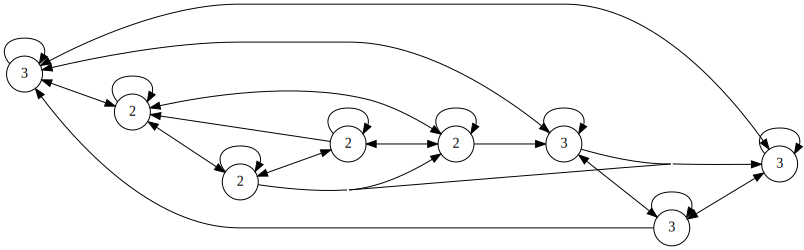

In [4]:
ans = louvain_cluster(M, 10)
labels = get_louvain_cluster_assignments(ans)
draw(M, show_weight=False, label_vector=labels)

In [14]:
from collections import defaultdict
from itertools import groupby
from operator import itemgetter

def group_labels(T):
    d = defaultdict(list)
    for k,v in groupby(T, itemgetter(1)):
        d[k].append(list(v)[0][0])
    return d

def compare_groups(left, right):
    left = {k: set(v) for k, v in left.items()}
    right = {k: set(v) for k, v in right.items()}
    result = [l ^ r for l, r in zip(sorted(left.values()), sorted(right.values()))]
    print(result)
    return left.values() == right.values()

In [12]:
sizes = [50, 100, 500, 1000, 5000]

Ns = []
for size in sizes:
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes.tsv' % size) as challenge:
        data = Matrix.from_tsv(challenge, FP64, size, size)
        print(size)
        ans = louvain_cluster(data, max_iters=10, seed=13)
        Ns.append(get_louvain_cluster_assignments(ans))

50
100
500
1000
5000


In [8]:
Ts = []
for size in sizes:
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes_truePartition.tsv' % size) as truth:
        T = Vector.from_type(UINT8, size)
        for line in truth:
            i, j = map(int, line.split('\t'))
            T[i-1] = j
        Ts.append(T)


In [15]:
for left, right in zip(Ns, Ts):
    print(compare_groups(group_labels(left), group_labels(right)))

[{23}, {23}, set()]
False
[set(), {71, 75, 12, 14, 15, 81, 25, 26, 29, 33, 37, 40, 43, 46, 48, 52, 60, 61}, {65, 4, 5, 71, 72, 10, 75, 12, 77, 14, 16, 81, 19, 83, 23, 25, 27, 31, 33, 98, 36, 37, 39, 40, 43, 46, 48, 51, 52, 53, 55, 57, 62}, {65, 5, 72, 8, 10, 74, 77, 13, 78, 16, 80, 19, 83, 23, 24, 92, 31, 95, 36, 39, 44, 47, 51, 53, 55, 57}]
False
[set(), set(), set(), set(), {275, 22, 25, 29, 44, 302, 48, 52, 311, 315, 63, 67, 69, 333, 340, 90, 91, 346, 95, 98, 356, 102, 106, 365, 114, 379, 126, 129, 388, 135, 141, 404, 149, 153, 160, 162, 164, 423, 426, 177, 433, 438, 443, 188, 189, 200, 457, 462, 469, 215, 220, 222, 483, 230, 234, 235, 237, 242, 499, 250}, set(), set()]
False
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
False
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
False
